In [1]:
# Imports + load data
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# for reproducibility change the working directory accordingly
df = pd.read_csv("C:Students Social Media Addiction.csv")
df.head()


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [2]:
# top 3 dominant platforms
platform_col = "Most_Used_Platform"

platform_counts = df[platform_col].value_counts()
top3 = platform_counts.index[:3].tolist()

print("Top 3 platforms:", top3)
for p in top3:
    print(f"{p}: n = {platform_counts[p]}")


Top 3 platforms: ['Instagram', 'TikTok', 'Facebook']
Instagram: n = 249
TikTok: n = 154
Facebook: n = 123


In [3]:
# preprocessing
x = "Avg_Daily_Usage_Hours"
m = "Addicted_Score"
y = "Mental_Health_Score"
platform_col = "Most_Used_Platform"

controls_raw = ["Age", "Sleep_Hours_Per_Night", "Gender", "Academic_Level"]

required = controls_raw + [x, m, y, platform_col]
data = df.dropna(subset=required).copy()

# dataset for descriptives (before dummies)
desc_data = df.dropna(subset=required).copy()

print("Final sample size:", len(desc_data))

# Age
print("\nAge:")
print(desc_data["Age"].agg(["mean", "std", "min", "max"]))

# Gender (%)
print("\nGender (%):")
print(desc_data["Gender"].value_counts(normalize=True) * 100)

# Academic level
print("\nAcademic level:")
print(desc_data["Academic_Level"].value_counts())

# Platform distribution
print("\nPlatform distribution:")
print(desc_data["Most_Used_Platform"].value_counts())


# Dummy-variables
data = pd.get_dummies(data, columns=["Gender", "Academic_Level"], drop_first=True)

# Ensure numeric 
for col in [x, m, y, "Age", "Sleep_Hours_Per_Night"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")
data = data.dropna(subset=[x, m, y, "Age", "Sleep_Hours_Per_Night"])

# Controls for regression after dummy
control_cols = ["Age", "Sleep_Hours_Per_Night"] + \
               [c for c in data.columns if c.startswith("Gender_") or c.startswith("Academic_Level_")]

print("Final sample size:", len(data))
print("Control columns used:", control_cols)


Final sample size: 705

Age:
mean    20.659574
std      1.399217
min     18.000000
max     24.000000
Name: Age, dtype: float64

Gender (%):
Gender
Female    50.070922
Male      49.929078
Name: proportion, dtype: float64

Academic level:
Academic_Level
Undergraduate    353
Graduate         325
High School       27
Name: count, dtype: int64

Platform distribution:
Most_Used_Platform
Instagram    249
TikTok       154
Facebook     123
WhatsApp      54
Twitter       30
LinkedIn      21
WeChat        15
Snapchat      13
VKontakte     12
LINE          12
KakaoTalk     12
YouTube       10
Name: count, dtype: int64
Final sample size: 705
Control columns used: ['Age', 'Sleep_Hours_Per_Night', 'Gender_Male', 'Academic_Level_High School', 'Academic_Level_Undergraduate']


In [4]:
# descriptive statistics
desc_vars = [
    x,
    m,
    y,
    "Sleep_Hours_Per_Night",
    "Age"
]

data[desc_vars].agg(["mean", "std"]).T



,mean,std
Avg_Daily_Usage_Hours,4.918723,1.257395
Addicted_Score,6.436879,1.587165
Mental_Health_Score,6.226950,1.105055
Sleep_Hours_Per_Night,6.868936,1.126848
Age,20.659574,1.399217


In [5]:
#platform specific
platforms = ["Instagram", "TikTok", "Facebook"]

data[data["Most_Used_Platform"].isin(platforms)] \
    .groupby("Most_Used_Platform")[desc_vars] \
    .agg(["mean", "std"])

Avg_Daily_Usage_Hours           Addicted_Score            \
                                    mean       std           mean       std   
Most_Used_Platform                                                            
Facebook                        4.507317  1.109583       5.666667  1.435308   
Instagram                       4.872289  1.237875       6.554217  1.536542   
TikTok                          5.346104  1.053419       7.428571  1.040721   

                   Mental_Health_Score           Sleep_Hours_Per_Night  \
                                  mean       std                  mean   
Most_Used_Platform                                                       
Facebook                      6.715447  1.028450              7.360163   
Instagram                     6.124498  1.172846              7.021285   
TikTok                        5.714286  0.797990              6.362987   

                                    Age            
                         std       mean       std  
Most_Used_Platform                                 
Facebook            0.988768  21.325203  1.162924  
Instagram           1.180038  20.168675  1.203013  
TikTok              1.131426  20.415584  1.370565

In [6]:
# OLS + Bootstrap Mediation

def ols(y, X):
    """
    OLS helper:
    - convert y and X to numeric
    - drop missing rows
    - convert to NumPy float arrays (prevents 'object dtype' errors)
    """
    tmp = pd.concat([y, X], axis=1)

    # Force numeric; non-numeric becomes NaN
    tmp = tmp.apply(pd.to_numeric, errors="coerce")

    # Drop rows with any missing values
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

    y_clean = tmp.iloc[:, 0].to_numpy(dtype=float)
    X_clean = tmp.iloc[:, 1:]

    # Add intercept
    X_clean = sm.add_constant(X_clean, has_constant="add").to_numpy(dtype=float)

    return sm.OLS(y_clean, X_clean).fit()

def bootstrap_mediation(data, x, m, y, controls, n_boot=2000, seed=1):
    rng = np.random.default_rng(seed)
    n = len(data)
    idx = np.arange(n)

    # Design matrices (just column selection)
    Xm, ym = data[[x] + controls], data[m]          # M ~ X + controls
    Xy, yy = data[[x, m] + controls], data[y]       # Y ~ X + M + controls
    Xt, yt = data[[x] + controls], data[y]          # Y ~ X + controls

    # Point estimates
    fm = ols(ym, Xm)
    fy = ols(yy, Xy)
    ft = ols(yt, Xt)

    a = fm.params[1]          # NOTE: params[1] corresponds to X (because intercept is params[0])
    b = fy.params[2]          # NOTE: in Y model: params = [const, X, M, controls...]
    indirect = a * b
    direct = fy.params[1]     # direct effect of X (c')
    total = ft.params[1]      # total effect of X (c)
    prop_med = indirect / total if total != 0 else np.nan

    # Bootstrap indirect effect a*b
    boots = []
    for _ in range(n_boot):
        s = rng.choice(idx, size=n, replace=True)
        try:
            fm_s = ols(ym.iloc[s], Xm.iloc[s])
            fy_s = ols(yy.iloc[s], Xy.iloc[s])

            a_s = fm_s.params[1]
            b_s = fy_s.params[2]
            boots.append(a_s * b_s)
        except Exception:
            pass

    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])

    return {
        "n": n,
        "n_boot_used": len(boots),
        "a_path": a,
        "b_path": b,
        "indirect_ab": indirect,
        "ci_low": ci_low,
        "ci_high": ci_high,
        "direct_cprime": direct,
        "total_c": total,
        "prop_mediated": prop_med,
    }
# check if everything is numeric
check_cols = [x, m, y] + control_cols
print(data[check_cols].dtypes.value_counts())


int64      3
bool       3
float64    2
Name: count, dtype: int64


In [7]:
# Full-sample mediation
# 1) Build the final list of control columns AFTER dummy coding
#    (Gender_... and Academic_Level_... are the dummy columns created by get_dummies)
control_cols = ["Age", "Sleep_Hours_Per_Night"] + [
    c for c in data.columns
    if c.startswith("Gender_") or c.startswith("Academic_Level_")
]

print("Controls used:", control_cols)

# 2) Run mediation on the full sample
res_all = bootstrap_mediation(
    data=data,
    x=x, m=m, y=y,
    controls=control_cols,
    n_boot=5000,   # increase to 5000 for final paper if runtime allows
    seed=1
)

# 3) Print results
print("\n--- RQ1: Full sample mediation ---")
print(f"n = {res_all['n']} (bootstraps used: {res_all['n_boot_used']})")
print(f"a (X -> M) = {res_all['a_path']:.4f}")
print(f"b (M -> Y | X) = {res_all['b_path']:.4f}")
print(f"Indirect (a*b) = {res_all['indirect_ab']:.4f} "
      f"CI [{res_all['ci_low']:.4f}, {res_all['ci_high']:.4f}]")
print(f"Direct (c') = {res_all['direct_cprime']:.4f}")
print(f"Total (c) = {res_all['total_c']:.4f}")
print(f"Proportion mediated = {res_all['prop_mediated']:.4f}")

Controls used: ['Age', 'Sleep_Hours_Per_Night', 'Gender_Male', 'Academic_Level_High School', 'Academic_Level_Undergraduate']

--- RQ1: Full sample mediation ---
n = 705 (bootstraps used: 5000)
a (X -> M) = 0.7773
b (M -> Y | X) = -0.6459
Indirect (a*b) = -0.5021 CI [-0.5471, -0.4601]
Direct (c') = -0.0826
Total (c) = -0.5847
Proportion mediated = 0.8587


In [8]:
# RQ2: Platform-specific analysis

results = []

for p in top3:
    # Subset data to users whose most-used platform is p
    sub = data[data[platform_col] == p].copy()

    print(f"\nRunning mediation for {p} (n = {len(sub)})")

    # Run the same mediation model as in RQ1
    res_p = bootstrap_mediation(
        data=sub,
        x=x,
        m=m,
        y=y,
        controls=control_cols,
        n_boot=5000,
        seed=1
    )

    # Store results
    res_p["platform"] = p
    results.append(res_p)

# Combine results into a DataFrame
platform_results = pd.DataFrame(results)

platform_results



Running mediation for Instagram (n = 249)

Running mediation for TikTok (n = 154)

Running mediation for Facebook (n = 123)


,n,n_boot_used,a_path,b_path,indirect_ab,ci_low,ci_high,direct_cprime,total_c,prop_mediated,platform
0,249,5000,0.763545,-0.807689,-0.616707,-0.724899,-0.510392,0.120285,-0.496423,1.242303,Instagram
1,154,5000,0.565270,-0.694265,-0.392447,-0.475603,-0.316325,-0.223232,-0.615679,0.637422,TikTok
2,123,5000,0.878095,-0.643311,-0.564888,-0.654664,-0.477704,-0.019070,-0.583959,0.967343,Facebook


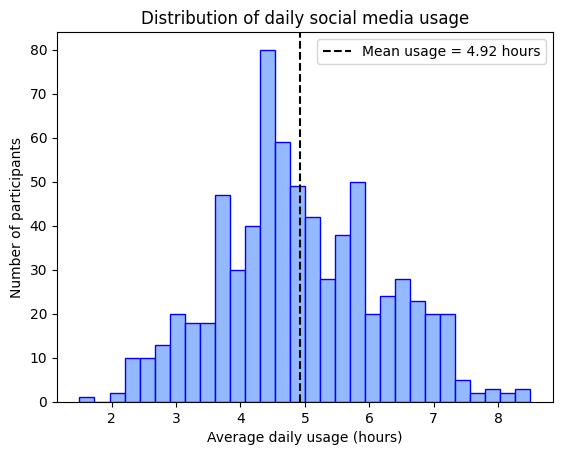

In [9]:
plt.figure()
plt.hist(data["Avg_Daily_Usage_Hours"], bins=30, color="#94b9ff", edgecolor="blue")
plt.xlabel("Average daily usage (hours)")
plt.ylabel("Number of participants")
plt.title("Distribution of daily social media usage")

mean_usage = data["Avg_Daily_Usage_Hours"].mean()
plt.axvline(mean_usage, color="black", linestyle="--", label=f"Mean usage = {mean_usage:.2f} hours")
plt.legend()
plt.show()

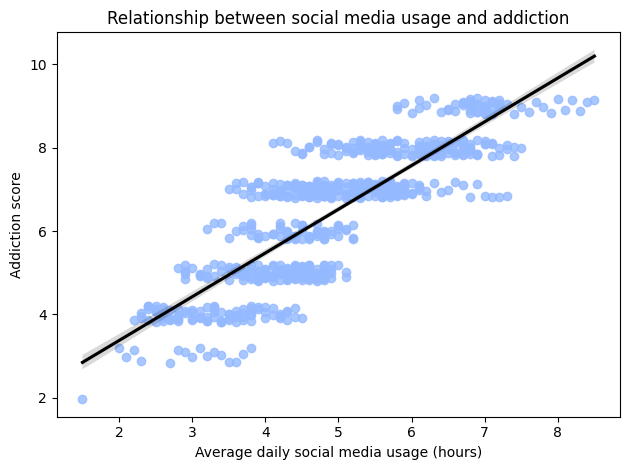

In [10]:
sns.regplot(
    color = "#94b9ff",
    data=data,
    x="Avg_Daily_Usage_Hours",
    y="Addicted_Score",
    line_kws={"color": "black"},
    y_jitter=0.2
    
)
plt.xlabel("Average daily social media usage (hours)")
plt.ylabel("Addiction score")
plt.title("Relationship between social media usage and addiction")

plt.tight_layout()
plt.show()

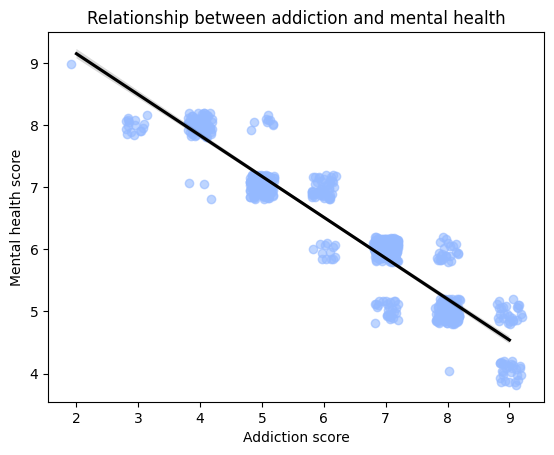

In [11]:
sns.regplot(
    data=data,
    color = "#94b9ff",
    x="Addicted_Score",
    y="Mental_Health_Score",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "black"},
    x_jitter=0.2,
    y_jitter=0.2
)

plt.xlabel("Addiction score")
plt.ylabel("Mental health score")
plt.title("Relationship between addiction and mental health")
plt.show()

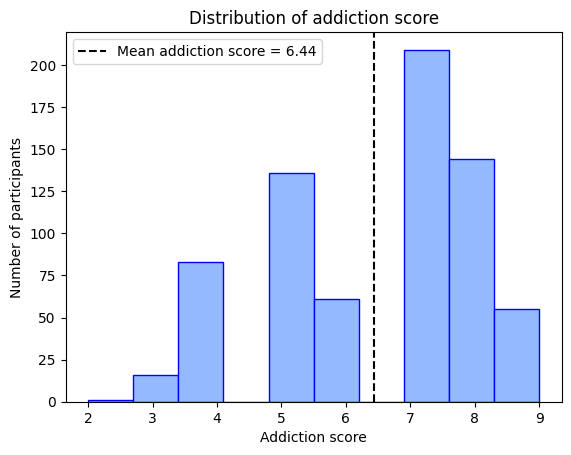

In [12]:
plt.figure()
plt.hist(data["Addicted_Score"], bins=10, color="#94b9ff", edgecolor="blue")
plt.xlabel("Addiction score")
plt.ylabel("Number of participants")
plt.title("Distribution of addiction score")

mean_usage = data["Addicted_Score"].mean()
plt.axvline(mean_usage, color="black", linestyle="--", label=f"Mean addiction score = {mean_usage:.2f}")
plt.legend()
plt.show()